# Learning new associations

Being able to learn an input-output mapping
(or a _heteroassociative memory_)
is useful for storing and recalling associations.
This is also a task required by more complicated models
that require some notion of long-term memory.

In a perfect world, the PES rule could be applied
to learn this mapping from examples.
However, when two distinct inputs cause the same neurons to fire,
their decoded values will depend on one another.
This leads to difficulty when trying to store
multiple independent associations in the same memory.

To solve this problem,
a vector-space analog of Oja's rule,
dubbed Vector-Oja's rule (or simply _Voja's rule_) was proposed.
In essence, this unsupervised learning rule
makes neurons fire selectively in response to their input.
When used in conjunction with properly-chosen intercepts
(corresponding to the largest dot-product between pairs of inputs),
this approach makes it possible to scalably
learn new associations in a spiking network.

Voja's rule works by moving the encoders
of the active neurons toward the current input.
This can be stated succinctly as,

$$
\Delta e_i = \kappa a_i (x - e_i)
$$

where $e_i$ is the encoder of the $i^{th}$ neuron,
$\kappa$ is a modulatory learning rate
(positive to move towards, and negative to move away),
$a_i$ is the filtered activity of the $i^{th}$ neuron,
and $x$ is the input vector encoded by each neuron.
To see how this is related to Oja's rule,
substituting $e_i$ with the row of weights $W_i$,
$x$ for the pre-synaptic activity vector $b$,
and letting $s = 1 / a_i$ be a dynamic normalizing factor, gives

$$
\Delta W_i = \kappa a_i (b - s a_i W_i)
$$

which is the update rule for a single row using Oja.
For more details,
see [Learning large-scale heteroassociative memories in spiking neurons](
http://compneuro.uwaterloo.ca/publications/voelker2014a.html).

This notebook will lead the reader through
a basic example of building a network
that can store and recall new associations.

## Step 1: Configure some example data

First, we will setup some keys (inputs) and values (outputs)
for our network to store and recall.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo

In [2]:
num_items = 5

d_key = 2
d_value = 4

rng = np.random.RandomState(seed=7)
keys = nengo.dists.UniformHypersphere(surface=True).sample(num_items, d_key, rng=rng)
values = nengo.dists.UniformHypersphere(surface=False).sample(
    num_items, d_value, rng=rng
)

An important quantity is the largest dot-product
between all pairs of keys,
since a neuron's intercept should not go below this value
if it's positioned between these two keys.
Otherwise, the neuron will move back and forth
between encoding those two inputs.

In [3]:
intercept = (np.dot(keys, keys.T) - np.eye(num_items)).flatten().max()
print("Intercept: %s" % intercept)

Intercept: 0.6952474346952748


## Step 2: Build the model

We define a helper function that is useful
for creating nodes that cycle through keys/values.

In [4]:
def cycle_array(x, period, dt=0.001):
    """Cycles through the elements"""
    i_every = int(round(period / dt))
    if i_every != period / dt:
        raise ValueError("dt (%s) does not divide period (%s)" % (dt, period))

    def f(t):
        i = int(round((t - dt) / dt))  # t starts at dt
        return x[int(i / i_every) % len(x)]

    return f

We create three inputs:
the keys, the values, and a modulatory learning signal.
The model is run continuously in two phases:
the first half learns the set of associations,
and the second tests recall.

The learning signal will be set to 0
o allow learning during the first phase,
and -1 to inhibit learning during the second phase.

The memory is confined to a single ensemble.
Roughly speaking, its encoders will hold the keys,
and its decoders will hold the values.

In [5]:
# Model constants
n_neurons = 200
dt = 0.001
period = 0.3
T = period * num_items * 2

# Model network
model = nengo.Network()
with model:

    # Create the inputs/outputs
    stim_keys = nengo.Node(output=cycle_array(keys, period, dt))
    stim_values = nengo.Node(output=cycle_array(values, period, dt))
    learning = nengo.Node(output=lambda t: -int(t >= T / 2))
    recall = nengo.Node(size_in=d_value)

    # Create the memory
    memory = nengo.Ensemble(n_neurons, d_key, intercepts=[intercept] * n_neurons)

    # Learn the encoders/keys
    voja = nengo.Voja(learning_rate=5e-2, post_synapse=None)
    conn_in = nengo.Connection(stim_keys, memory, synapse=None, learning_rule_type=voja)
    nengo.Connection(learning, conn_in.learning_rule, synapse=None)

    # Learn the decoders/values, initialized to a null function
    conn_out = nengo.Connection(
        memory,
        recall,
        learning_rule_type=nengo.PES(1e-3),
        function=lambda x: np.zeros(d_value),
    )

    # Create the error population
    error = nengo.Ensemble(n_neurons, d_value)
    nengo.Connection(
        learning, error.neurons, transform=[[10.0]] * n_neurons, synapse=None
    )

    # Calculate the error and use it to drive the PES rule
    nengo.Connection(stim_values, error, transform=-1, synapse=None)
    nengo.Connection(recall, error, synapse=None)
    nengo.Connection(error, conn_out.learning_rule)

    # Setup probes
    p_keys = nengo.Probe(stim_keys, synapse=None)
    p_values = nengo.Probe(stim_values, synapse=None)
    p_learning = nengo.Probe(learning, synapse=None)
    p_error = nengo.Probe(error, synapse=0.005)
    p_recall = nengo.Probe(recall, synapse=None)
    p_encoders = nengo.Probe(conn_in.learning_rule, "scaled_encoders")

## Step 3: Running the model

In [6]:
with nengo.Simulator(model, dt=dt) as sim:
    sim.run(T)
t = sim.trange()

## Step 4: Plotting simulation output

We first start by checking the keys, values, and learning signals.

(-1.2, 0.2)

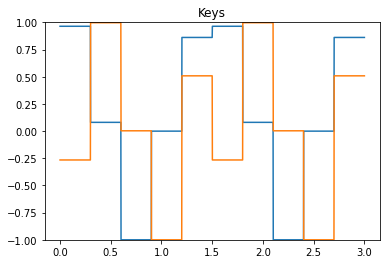

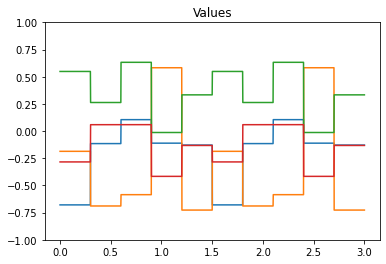

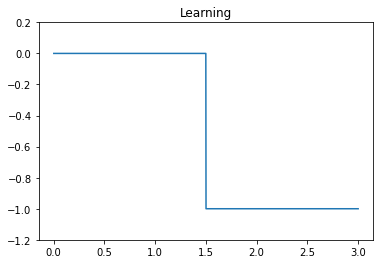

In [7]:
plt.figure()
plt.title("Keys")
plt.plot(t, sim.data[p_keys])
plt.ylim(-1, 1)

plt.figure()
plt.title("Values")
plt.plot(t, sim.data[p_values])
plt.ylim(-1, 1)

plt.figure()
plt.title("Learning")
plt.plot(t, sim.data[p_learning])
plt.ylim(-1.2, 0.2)

Next, we look at the error during training and testing.
In the top figure, the error being minimized by PES
goes to zero for each association during the training phase.
In the bottom figure, the recall error is close to zero,
with momentary spikes each time a new key is presented.

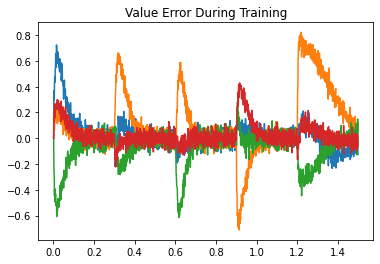

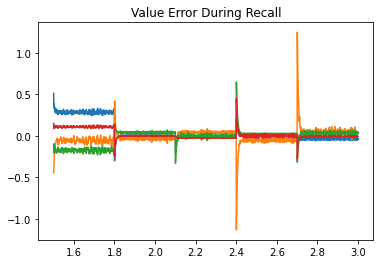

In [8]:
train = t <= T / 2
test = ~train

plt.figure()
plt.title("Value Error During Training")
plt.plot(t[train], sim.data[p_error][train])

plt.figure()
plt.title("Value Error During Recall")
plt.plot(t[test], sim.data[p_recall][test] - sim.data[p_values][test])

## Step 5: Examining encoder changes

We can also plot the two-dimensional encoders before and after training.
Initially, they are uniformly distributed around the unit circle.
Afterward, we see that each key has attracted all of its nearby neurons.
Notably, almost all neurons are participating
in the representation of a unique association.

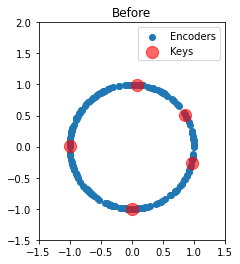

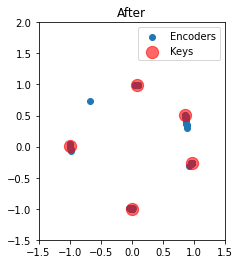

In [9]:
scale = (sim.data[memory].gain / memory.radius)[:, np.newaxis]


def plot_2d(text, xy):
    plt.figure()
    plt.title(text)
    plt.scatter(xy[:, 0], xy[:, 1], label="Encoders")
    plt.scatter(keys[:, 0], keys[:, 1], c="red", s=150, alpha=0.6, label="Keys")
    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 2)
    plt.legend()
    plt.gca().set_aspect("equal")


plot_2d("Before", sim.data[p_encoders][0].copy() / scale)
plot_2d("After", sim.data[p_encoders][-1].copy() / scale)